In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import util

In [2]:
class AutoEncoder:
    def __init__(self, input_size, latent_size, session, lamb, use_bias=True):
        self.input_size = input_size
        self.latent_size = latent_size
        self.use_bias = use_bias
        self.f = tf.nn.relu
        self.session = session
        self.lamb = lamb
        
        self.X = tf.placeholder(tf.float32, shape = (None, input_size), name = 'X')
        self.W1 = tf.Variable(tf.random_normal(shape=(input_size, latent_size))* 2 / np.sqrt(latent_size))
#        self.W1 = tf.Variable(np.zeros(input_size, latent_size).astype(np.float32))
        self.Z = tf.placeholder(tf.float32, shape = (None, latent_size), name = 'Z')
        self.W2 = tf.Variable(tf.random_normal(shape=(latent_size, input_size))* 2 / np.sqrt(input_size))
        self.Y = tf.placeholder(tf.float32, shape = (None, input_size), name = 'Y')
        
        if use_bias:
            self.b1 = tf.Variable(np.zeros(latent_size).astype(np.float32))
            self.b2 = tf.Variable(np.zeros(input_size).astype(np.float32))
            self.Z = self.f(   tf.matmul(self.X, self.W1) + self.b1   )
            self.Y = tf.matmul(self.Z, self.W2) + self.b2
        else:    
            self.Z = self.f(   tf.matmul(self.X, self.W1)   )
            self.Y = tf.matmul(self.Z, self.W2)
        
#        cost = np.mean(np.square(self.G - values_selected), axis = 0)
#        cost = tf.reduce_sum(tf.square(self.X - self.Y)) + self.lamb*(tf.reduce_sum(tf.square(self.W1))+tf.reduce_sum(tf.square(self.W2))) 
        self.cost = tf.reduce_sum( 
        tf.nn.sigmoid_cross_entropy_with_logits(
        targets=self.X, logits=self.Y   )
        )
        self.train_op = tf.train.AdamOptimizer(10e-3).minimize(self.cost)
        # self.train_op = tf.train.AdagradOptimizer(10e-3).minimize(self.cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-4, momentum=0.9).minimize(self.cost)
        # self.train_op = tf.train.GradientDescentOptimizer(10e-5).minimize(self.cost)
        # self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(self.cost)

#        self.cost = cost
        
        init_op = tf.initialize_all_variables()
        self.session.run(init_op)
        
        
    def train(self, X):
        self.session.run( self.train_op,  feed_dict={self.X : X } )

    def encode(self, X):
        X = np.atleast_2d(X).astype(np.float32)
        if self.use_bias:
            predict_Z = self.f(   tf.matmul(X, self.W1) + self.b1   )
        else:    
            predict_Z = self.f(   tf.matmul(X, self.W1)   )     
        return self.session.run(predict_Z )
    
    def decode(self, Z):
        Z = np.atleast_2d(Z).astype(np.float32)
        if self.use_bias:
            predict_Y = self.f(   tf.matmul(Z, self.W2) + self.b2   )
        else:    
            predict_Y = self.f(   tf.matmul(Z, self.W2)   )     
        return self.session.run(predict_Y)
    
    def fit(self, X, epochs, batch_sz):
        costs = []
        n_batches = len(X) // batch_sz
        print("n_batches:", n_batches)
        for i in range(epochs):
            print("epoch:", i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j+1)*batch_sz]
                _, c, = self.session.run((self.train_op, self.cost), feed_dict={self.X: batch})
                c /= batch_sz # just debugging
                costs.append(c)
                if j % 300 == 0:
                    print("iter: %d, cost: %.3f" % (j, c))
        plt.plot(costs)
        plt.show()

In [3]:
    X, Y = util.get_mnist()
    input_size = X.shape[1]      #   X.shape = (42000, 784)
    sess = tf.InteractiveSession()

Reading in and transforming data...


('n_batches:', 328)
('epoch:', 0)
iter: 0, cost: 613.635
iter: 300, cost: 58.009
('epoch:', 1)
iter: 0, cost: 56.720
iter: 300, cost: 54.817
('epoch:', 2)
iter: 0, cost: 55.190
iter: 300, cost: 53.322
('epoch:', 3)
iter: 0, cost: 51.046
iter: 300, cost: 52.874
('epoch:', 4)
iter: 0, cost: 52.479
iter: 300, cost: 52.122
('epoch:', 5)
iter: 0, cost: 52.478
iter: 300, cost: 50.968
('epoch:', 6)
iter: 0, cost: 53.063
iter: 300, cost: 51.127
('epoch:', 7)
iter: 0, cost: 51.144
iter: 300, cost: 52.144
('epoch:', 8)
iter: 0, cost: 52.051
iter: 300, cost: 54.102
('epoch:', 9)
iter: 0, cost: 51.926
iter: 300, cost: 51.976


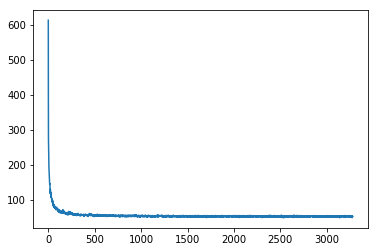

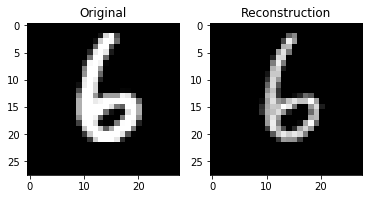

In [27]:
    latent_size = input_size/3
    lamb = 0.
   
    AE = AutoEncoder(input_size, latent_size, sess, lamb)
    
    AE.fit(X, epochs=10, batch_sz=128)
    X0 = X[0].reshape(1,784)
    Z0 = AE.encode(X0)
    Y0 = AE.decode(Z0)
    
    im_in = X0.reshape(28, 28)
    im_out = Y0.reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(im_in, cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im_out, cmap='gray')
    plt.title("Reconstruction")
    plt.show()


## TEST

### this version_01 doses not converge, the problem might be  not using 'mini-batch' in training.

In [2]:
class AutoEncoder:
    def __init__(self, input_size, latent_size, session, lamb, use_bias=True):
        self.input_size = input_size
        self.latent_size = latent_size
        self.use_bias = use_bias
        self.f = tf.nn.relu
        self.session = session
        self.lamb = lamb
        
        self.X = tf.placeholder(tf.float32, shape = (None, input_size), name = 'X')
        self.W1 = tf.Variable(tf.random_normal(shape=(input_size, latent_size)))
#        self.W1 = tf.Variable(np.zeros(input_size, latent_size).astype(np.float32))
        self.Z = tf.placeholder(tf.float32, shape = (None, latent_size), name = 'Z')
        self.W2 = tf.Variable(tf.random_normal(shape=(latent_size, input_size)))
        self.Y = tf.placeholder(tf.float32, shape = (None, input_size), name = 'Y')
        
        if use_bias:
            self.b1 = tf.Variable(np.zeros(latent_size).astype(np.float32))
            self.b2 = tf.Variable(np.zeros(input_size).astype(np.float32))
            self.Z = self.f(   tf.matmul(self.X, self.W1) + self.b1   )
            self.Y = tf.matmul(self.Z, self.W2) + self.b2
        else:    
            self.Z = self.f(   tf.matmul(self.X, self.W1)   )
            self.Y = tf.matmul(self.Z, self.W2)
        
#        cost = np.mean(np.square(self.G - values_selected), axis = 0)
        cost = tf.reduce_mean(tf.square(self.X - self.Y)) + self.lamb*(tf.reduce_mean(tf.square(self.W1))+tf.reduce_mean(tf.square(self.W2))) 
        # self.train_op = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6).minimize(cost)
        self.train_op = tf.train.AdamOptimizer(10e-3).minimize(cost)
        # self.train_op = tf.train.AdagradOptimizer(10e-3).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-4, momentum=0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(10e-5).minimize(cost)

        self.cost = cost
        
        init_op = tf.initialize_all_variables()
        self.session.run(init_op)
        
        
    def train(self, X):
        self.session.run( self.train_op,  feed_dict={self.X : X } )

    def encode(self, X):
        X = np.atleast_2d(X).astype(np.float32)
        if self.use_bias:
            predict_Z = self.f(   tf.matmul(X, self.W1) + self.b1   )
        else:    
            predict_Z = self.f(   tf.matmul(X, self.W1)   )     
        return self.session.run(predict_Z )
    
    def decode(self, Z):
        Z = np.atleast_2d(Z).astype(np.float32)
        if self.use_bias:
            predict_Y = self.f(   tf.matmul(Z, self.W2) + self.b2   )
        else:    
            predict_Y = self.f(   tf.matmul(Z, self.W2)   )     
        return self.session.run(predict_Y)

Reading in and transforming data...


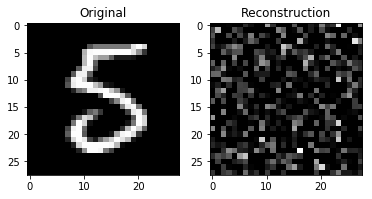

In [5]:
if __name__ == '__main__':
    
    X, Y = util.get_mnist()
    input_size = X.shape[1]      #   784
    latent_size = input_size/2   
    lamb = 0.01
    
    sess = tf.InteractiveSession()
    
   
    AE = AutoEncoder(input_size, latent_size, sess, lamb)
    
    

    AE.train(X)
    X0 = X[0].reshape(1,784)
    Z0 = AE.encode(X0)
    Y0 = AE.decode(Z0)
    
    im_in = X0.reshape(28, 28)
    im_out = Y0.reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(im_in, cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im_out, cmap='gray')
    plt.title("Reconstruction")
    plt.show()


### version_00_beta is not completed. this is originally intended
###  to imitate the way in 'my_dqn_tf_breakout '

In [ ]:
class AutoEncoder:
    def __init__(self, num_input, num_latent):
        self.num_input = num_input
        self.num_latent = num_latent
        self.scope = scope
        self.sess = session
      
        self.G = tf.placeholder(tf.float32, shape = (None,), name = 'G') 
        self.X = tf.placeholder(tf.float32, shape = (None, 4, IM_SIZE, IM_SIZE),
                                    name = 'X' )
#        self.X = X

        self.X = tf.placeholdder(tf.float32, shape = (None, num_input), name = 'X')
        self.W1 = tf.placeholdder(type = 'float', shape=(num_input, num_latent))
        self.Z = tf.placeholdder(tf.float32, shape = (None, num_latent), name = 'Z')
        self.W1 = tf.placeholdder(type = 'float', shape=(num_latent, num_input))
        self.Y = tf.placeholdder(tf.float32, shape = (None, num_input), name = 'Y')
    
        Z = tf.contrib.layers.flatten(Z)
        Z = tf.contrib.layers.fully_connected(Z, num_input, activation_fn=tf.nn.relu)
        self.Y = tf.contrib.layers.fully_connected(Z, num_latent)

        
        
        
        
        
            values_selected  = tf.reduce_sum(
              self.predict_op * tf.one_hot(self.action, K),
              reduction_indices=[1]      )
#            cost = np.mean(np.square(self.G - values_selected), axis = 0)
            cost = tf.reduce_mean(tf.square(self.G - values_selected))        
            self.train_op = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6).minimize(cost)
            self.cost = cost
    
    
    
    
    
    
    def train(self):
        self.Z = tf.activation.relu(tf.matmul(self.X, self.W1))
        self.Y = tf.matmul(self.Z, self.W2)
        loss = (self.X - self.Y)**2
        optimizer
        mizimize(loss)
    
    def encode(self, X):
        
        predict_Z = tf.activation.relu(tf.matmul(X, self.W1))
        
        return predict_Z 
    
    def generate(self, Z)
        
        predict_Y = tf.matmul(Z, self.W2)
        
        return predict_Y 